In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from copy import deepcopy
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import math

torch.manual_seed(1)

# 1 Import Data functions

In [2]:
def grabDataThigh(filename : str, header = 1,):
    types = defaultdict(float, A=str)
    df = pd.read_csv(filename,header=header,dtype=types)
    dfThigh = df.loc[df["type"]=="t"]
    return dfThigh

def fixTimeData(df : pd.DataFrame):
    data = deepcopy(df)
    datadict = data.to_dict("list")
    timeValues = []
    x = datadict["time"]
    for i in range(len(x)):
        xValues = re.findall(r'[0-9.]+',x[i])
        tmpTime = 360*float(xValues[0])
        tmpTime = tmpTime + 60*float(xValues[1])
        tmpTime = tmpTime + float(xValues[2])
        timeValues.append(tmpTime)
    datadict["time"] = timeValues
    
    return datadict

def fixData(data : dict, normalize, Time : bool, FSR : bool, Grav : bool, Gyro : bool, Quat : bool, LiAcc :bool, Classification : bool):
    '''
    For normalization, set normalize = "minmax" for min-max normalization, or normalize = "z-score" for standardization 
    '''

    DataList = list(data.items())
    popList = []
    for i in range(len(DataList)):
        if "time" in DataList[i][0] and not Time:
            popList.append(i)
        if "FSR" in DataList[i][0] and not FSR:
            popList.append(i)
        if "Grav" in DataList[i][0] and not Grav:
            popList.append(i)
        if "Gyro" in DataList[i][0] and not Gyro:
            popList.append(i)
        if "Quat" in DataList[i][0] and not Quat:
            popList.append(i)
        if "LiAcc" in DataList[i][0] and not LiAcc:
            popList.append(i)
        if "Cal" in DataList[i][0] and not "Gyro" in DataList[i][0]:
            popList.append(i)
        if "GyroCal" in DataList[i][0]:
            popList.append(i)
        if "Class" in DataList[i][0] and not Classification:
            popList.append(i)
        if "index" in DataList[i][0]:
            popList.append(i)
    for i in range(len(popList)):
        DataList.pop(popList[i]-i)
    if normalize == "minmax":
        newDict = {}
        for key, column in DataList:
            if key != "class":
                data = np.array(column)
                column = list((data - min(data)) / (max(data) - min(data)))
                newDict[key] = column
            else:
                newDict[key] = column
        return newDict
    if normalize == "z-score":
        newDict = {}
        for key, column in DataList:
            if key != "class":
                data = np.array(column)
                column = list((data - data.mean()) / data.std())
                newDict[key] = column
            else:
                newDict[key] = column
        return newDict
    return dict(DataList)

def processFSR(data : dict, FSR : bool, sum : bool, avg : bool):
    dataDict = {}
    df = pd.DataFrame(data)
    additional = pd.DataFrame()
    FSRSum = df.sum(axis=1)
    FSRSum = pd.DataFrame(FSRSum)
    additional["FSRSum"] = FSRSum
    FSRAvg = FSRSum.div(len(df.columns))
    FSRAvg = pd.DataFrame(FSRAvg)
    additional["FSRAvg"] = FSRAvg
    if FSR:
        if sum:
            df["FSRsum"] = additional["FSRSum"]
        if avg:
            df["FSRavg"] = additional["FSRAvg"]
        data = df.to_dict("list")
    elif sum and avg:
        data = additional.to_dict("list")
    elif sum:
        df = additional.to_dict("list")
        dataDict["FSRSum"] = df["FSRSum"]
        return dataDict
    elif avg:
        df = additional.to_dict("list")
        dataDict["FSRAvg"] = df["FSRAvg"]
        return dataDict
    return data

def dictExtension(ListOfData : list):
    DataList = list(ListOfData[0].items())
    for i in range(1,len(ListOfData)):
        for j in range(len(DataList)):
            listData = list(ListOfData[i].items())
            tmpList = listData[j][1]
            DataList[j][1].extend(tmpList)
    dataDict = dict(DataList)
    return dataDict


def plot3FSRComparisons(dataList : list):
    fig, ax = plt.subplots(1,3,sharey=True,figsize=(15,6))
    for i in range(len(dataList)):
        tmpDictList = list(dataList[i].items())
        for j in range(1,len(tmpDictList)):
            if "FSR" in tmpDictList[j][0]:
                x = list(k-tmpDictList[0][1][0] for k in tmpDictList[0][1]) 
                ax[i].plot(x,tmpDictList[j][1],label=f"FSR {j}")
    plt.legend()
    plt.show()

def prepareSingleSequenceInput(dataDict):
    """
    Converts a feature-wise dictionary into an LSTM-compatible tensor.

    Parameters:
        dataDict (dict): Dictionary where each of the 26 keys maps to a list of values representing the sequence.

    Returns:
        torch.Tensor: Tensor of shape (seqLen, 1, inputSize=26)
    """
    featureNames = sorted(dataDict.keys())  # sort keys to maintain order
    seqLen = len(next(iter(dataDict.values())))
    inputSize = len(featureNames)

    # Stack features into shape: (seqLen, inputSize)
    sequence = [[dataDict[feat][t] for feat in featureNames] for t in range(seqLen)]
    # Convert to tensor and add batch dimension: (seqLen, 1, inputSize)
    tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(1)
    return tensor

class SequenceDataset(Dataset):
    def __init__(self, fullSequence, seqLen=100):
        """
        fullSequence: tensor of shape (totalLen, inputSize)
        """
        self.seqLen = seqLen
        self.data = fullSequence
        self.samples = self.createSequences()

    def createSequences(self):
        sequences = []
        for i in range(len(self.data) - self.seqLen):
            seq = self.data[i:i+self.seqLen]
            label = self.data[i+self.seqLen]  # e.g. next step prediction
            sequences.append((seq, label))
        return sequences

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
def checkDictForStr(data :dict):
    for j in data:
        for i in range(len(data[j])):
            if isinstance(data[j][i],str):
                data[j][i] = float(data[j][i])
    return data

In [3]:
Time = False
FSR = True     # val: 98.89 test: 87.59%
FSRsum = False    # val: 98.89 test: 91.97%
FSRavg = False     # val: 98.89 test: 91.97%
Grav = True    # val: 78.28 test: 85
Gyro = True    # val: 98.01 test 87.53
Quat = True    # val: 98.94 test: 94.19
LiAcc = True   # val: 97.06 test: 81.22
Classification = True
normalize = "minmax"

filename = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Jonas 6 min.txt"
with open(filename) as f:
    firstline = f.readline()
    f.close()
sampleRate = re.findall(r'[0-9.]+',firstline)
print(sampleRate)

wantedTime = 0.5
timeStep = 1#math.floor(float(sampleRate[0])/(1/wantedTime))
if timeStep == 1:
    wantedTime = round(1/float(sampleRate[0]),4)


# FSR + sum + Quat = 98.96 val 94.28 test

inputSize = sum([FSR*8,FSRsum,FSRavg,Grav*3,Gyro*3,Quat*4,LiAcc*3,Classification])
print(inputSize)


['135.22252747252747']
22


# 2 Load model

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, inputSize=25, hiddenSize=50, numLayers=1, outputSize=25):
        super(LSTMModel, self).__init__()
        
        self.hiddenSize = hiddenSize
        self.numLayers = numLayers
        
        # LSTM Layer
        self.lstm = nn.LSTM(inputSize, hiddenSize, numLayers, batch_first=True)
        
        # Fully connected output layer
        self.fc = nn.Linear(hiddenSize, outputSize)

    def forward(self, x):
        # x: (batchSize, seqLen, inputSize)
        h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize).to(x.device)
        c0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))  # out: (batchSize, seqLen, hiddenSize)
        
        # Only use the output from the last time step
        out = self.fc(out[:, -1, :])
        
        return out

In [5]:
model = LSTMModel(inputSize=inputSize,outputSize=inputSize)
model.load_state_dict(torch.load(r"C:\Users\jonas\Documents\GitHub\P8\Code\NormClassLSTM.pt"))
lossFn = nn.MSELoss()

C:\Users\jonas\AppData\Local\Temp\ipykernel_19812\408703747.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\jonas\Documents\G

# 3 TestData

Upstairs data first, then downstairs, then straight walk

In [6]:
upstairsFilename1 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Frederik upstairs.txt"
upstairsFilename2 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Jakob Upstairs1.csv"
upstairsFilename3 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Jakob Upstairs2.csv"
upstairsFilename4 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Svend upstairs.txt"

dfUpstairs1 = grabDataThigh(upstairsFilename1)
dataUpstairs1 = fixTimeData(dfUpstairs1)
dataUpstairs1.pop('type')
dataUpstairs1["Class"] = list(1 for i in range(len(dataUpstairs1["time"])))

dfUpstairs2 = grabDataThigh(upstairsFilename2,0)
dataUpstairs2 = dfUpstairs2.to_dict("list")
dataUpstairs2.pop('type')
dataUpstairs2["Class"] = list(1 for i in range(len(dataUpstairs2["time"])))

dfUpstairs3 = grabDataThigh(upstairsFilename3,0)
dataUpstairs3 = dfUpstairs3.to_dict("list")
dataUpstairs3.pop('type')
dataUpstairs3["Class"] = list(1 for i in range(len(dataUpstairs3["time"])))

dfUpstairs4 = grabDataThigh(upstairsFilename4)
dataUpstairs4 = fixTimeData(dfUpstairs4)
dataUpstairs4.pop('type')
dataUpstairs4["Class"] = list(1 for i in range(len(dataUpstairs4["time"])))


In [7]:
downstairsFilename1 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Frederik downstairs.txt"
downstairsFilename2 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Jakob downstairs1.csv"
downstairsFilename3 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Jakob downstairs2.csv"
downstairsFilename4 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Svend downstairs.txt"
downstairsFilename5 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Asbjørn downstairs.txt"

dfdownstairs1 = grabDataThigh(downstairsFilename1)
dataDownstairs1 = fixTimeData(dfdownstairs1)
dataDownstairs1.pop('type')
dataDownstairs1["Class"] = list(-1 for i in range(len(dataDownstairs1["time"])))

dfdownstairs2 = grabDataThigh(downstairsFilename2,0)
dataDownstairs2 = dfdownstairs2.to_dict("list")
dataDownstairs2.pop('type')
dataDownstairs2["Class"] = list(-1 for i in range(len(dataDownstairs2["time"])))

dfdownstairs3 = grabDataThigh(downstairsFilename3,0)
dataDownstairs3 = dfdownstairs3.to_dict("list")
dataDownstairs3.pop('type')
dataDownstairs3["Class"] = list(-1 for i in range(len(dataDownstairs3["time"])))

dfdownstairs4 = grabDataThigh(downstairsFilename4)
dataDownstairs4 = fixTimeData(dfdownstairs4)
dataDownstairs4.pop('type')
dataDownstairs4["Class"] = list(-1 for i in range(len(dataDownstairs4["time"])))

dfdownstairs5 = grabDataThigh(downstairsFilename5)
dataDownstairs5 = fixTimeData(dfdownstairs5)
dataDownstairs5.pop('type')
dataDownstairs5["Class"] = list(-1 for i in range(len(dataDownstairs5["time"])))


In [8]:
walkFilename1 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Frederik walk.txt"
walkFilename2 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Jakob walk 8.txt"
walkFilename3 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Svend walk.txt"
walkFilename4 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Asbjørn walk.txt"
walkFilename5 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\August 6 min walk.txt"

dfWalk1 = grabDataThigh(walkFilename1)
dataWalk1 = fixTimeData(dfWalk1)
dataWalk1.pop('type')
dataWalk1["Class"] = list(0 for i in range(len(dataWalk1["time"])))
print("1 Works")

dfWalk2 = grabDataThigh(walkFilename2)
dataWalk2 = fixTimeData(dfWalk2)
dataWalk2.pop('type')
dataWalk2["Class"] = list(0 for i in range(len(dataWalk2["time"])))
print("2 Works")

dfWalk3 = grabDataThigh(walkFilename3)
dataWalk3 = fixTimeData(dfWalk3)
dataWalk3.pop('type')
dataWalk3["Class"] = list(0 for i in range(len(dataWalk3["time"])))
print("3 Works")

dfWalk4 = grabDataThigh(walkFilename4)
dataWalk4 = fixTimeData(dfWalk4)
dataWalk4.pop('type')
dataWalk4["Class"] = list(0 for i in range(len(dataWalk4["time"])))
print("4 Works")

dfWalk5 = grabDataThigh(walkFilename5)
dataWalk5 = fixTimeData(dfWalk5)
dataWalk5.pop('type')
dataWalk5["Class"] = list(0 for i in range(len(dataWalk5["time"])))

print("5 Works")

1 Works


C:\Users\jonas\AppData\Local\Temp\ipykernel_19812\2906205059.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename,header=header,dtype=types)


2 Works
3 Works
4 Works
5 Works


# Load all Data

In [9]:
# Data seperated by subjects
dataList1 = [dataWalk1,dataUpstairs1,dataDownstairs1]
dataList2 = [dataWalk2,dataUpstairs2,dataDownstairs2]
dataList3 = [dataWalk3,dataUpstairs4,dataDownstairs4]
dataList4 = [dataWalk4,dataDownstairs5]
dataList5 = [dataWalk5]

peopleData = [dataList1,dataList2,dataList3,dataList4,dataList5]

# Data seperated by movement
upStairsData = [dataUpstairs1,dataUpstairs2,dataUpstairs3,dataUpstairs4]
downStairsData = [dataDownstairs1,dataDownstairs2,dataDownstairs3,dataDownstairs4,dataDownstairs5]
walkData = [dataWalk1,dataWalk2,dataWalk3,dataWalk4,dataWalk5]

TotalList = [upStairsData,downStairsData,walkData]

#plot3FSRComparisons(j)
def adjustTestData(data : list, normalized = None):
    for k in range(len(data)):
        for i in range(len(data[k])):
            data[k][i] = checkDictForStr(data[k][i])
            data[k][i] = fixData(data[k][i],normalized,Time,True,Grav,Gyro,Quat,LiAcc,Classification)
            data[k][i] = processFSR(data[k][i], FSR, FSRsum, FSRavg)
            data[k][i] = prepareSingleSequenceInput(data[k][i])
            data[k][i] = SequenceDataset(data[k][i],250)[::timeStep]
            data[k][i] = DataLoader(data[k][i],batch_size=32)
    return data

TotalList = adjustTestData(TotalList,normalize)
peopleData = adjustTestData(peopleData,normalize)


C:\Users\jonas\AppData\Local\Temp\ipykernel_19812\2906205059.py:57: RuntimeWarning: invalid value encountered in true_divide
  column = list((data - min(data)) / (max(data) - min(data)))
C:\Users\jonas\AppData\Local\Temp\ipykernel_19812\2906205059.py:57: RuntimeWarning: invalid value encountered in true_divide
  column = list((data - min(data)) / (max(data) - min(data)))
C:\Users\jonas\AppData\Local\Temp\ipykernel_19812\2906205059.py:57: RuntimeWarning: invalid value encountered in true_divide
  column = list((data - min(data)) / (max(data) - min(data)))
C:\Users\jonas\AppData\Local\Temp\ipykernel_19812\2906205059.py:57: RuntimeWarning: invalid value encountered in true_divide
  column = list((data - min(data)) / (max(data) - min(data)))
C:\Users\jonas\AppData\Local\Temp\ipykernel_19812\2906205059.py:57: RuntimeWarning: invalid value encountered in true_divide
  column = list((data - min(data)) / (max(data) - min(data)))
C:\Users\jonas\AppData\Local\Temp\ipykernel_19812\2906205059.py:5

# Test code

In [10]:
def test(model, testLoader, lossFn, device):
    model.eval()  # Set the model to evaluation mode
    testLoss = 0
    testMaeTotal = 0
    i = False
    scalingFactor = 1
    yTestTrue = []
    yTestPred = []
    all_targets = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation for testing
        for batch in testLoader:
            batchX, batchY = batch
            batchX, batchY = batchX.to(device), batchY.to(device)
            
            batchX = batchX.float()
            batchX = batchX.squeeze(2)
            batchY = batchY.float()
            batchY = batchY.squeeze(1)
            batchX = torch.nan_to_num(batchX, nan=0.0)
            batchY = torch.nan_to_num(batchY, nan=0.0)

            # Forward pass
            outputs = model(batchX)

            # To avoid division by zero, add a small epsilon where targets are 0:

            if i:
                pred = outputs[0].squeeze(0).squeeze(0).cpu().numpy()
                scalingFactor = batchY[0].squeeze(0).squeeze(0).cpu().numpy()/pred
                i = False
            # Scale model output
            outputs = outputs*scalingFactor
            
            # Compute loss
            loss = lossFn(outputs, batchY)
            testLoss += loss.item()

            # Compute MAE
            testMaeTotal += F.l1_loss(outputs, batchY).item()

            # Collect true and predicted values for R²
            yTestTrue.append(batchY.cpu())
            yTestPred.append(outputs.cpu())
            all_targets.append(batchY.detach().cpu())
            all_predictions.append(outputs.detach().cpu())

    # Calculate average test loss and MAE
    avgTestLoss = testLoss / len(testLoader)
    avgTestMae = testMaeTotal / len(testLoader)
    avgRMSE = avgTestLoss**0.5
    
    '''
    targets_tensor = torch.cat(all_targets, dim=0)
    preds_tensor = torch.cat(all_predictions, dim=0)
    targets = targets_tensor.reshape(-1)[1:]
    preds = preds_tensor.reshape(-1)[1:]
    epsilon = 1e-8  # Avoid division by zero
    percentage_errors = (targets - preds).abs() / (targets.abs() + epsilon)
    mape = percentage_errors.mean().item() * 100  # percentage
    '''


    # Flatten the predictions and batchY to calculate R²
    yTestTrue = torch.cat(yTestTrue).numpy().flatten()
    yTestPred = torch.cat(yTestPred).numpy().flatten()
    testR2 = r2_score(yTestTrue, yTestPred)



    print(f"Test Loss: {avgTestLoss:.4f}, Test MAE: {avgTestMae:.4f}, Test R²: {testR2:.4f}, Test RMSE: {avgRMSE}")

    return avgTestLoss, avgTestMae, testR2, avgRMSE

def testLoop(data : list, model, lossFN, device):
    m, n = 0, 0
    ResultList = []
    tmpList = []
    MapeList = []
    for i in data:
        ResultList = []
        for k in i:
            tmpMSE, tmpMAE, tmpR2, Mape = test(model, k, lossFN, device)
            tmpResult = [tmpMAE,tmpMSE,tmpR2,Mape]
            ResultList.append(tmpResult)
        tmpList.append(ResultList)

    return tmpList

In [11]:
peopleResults = testLoop(peopleData, model, lossFn, "cpu")
movementResults = testLoop(TotalList, model, lossFn, "cpu")

Test Loss: 0.0911, Test MAE: 0.2274, Test R²: -0.3366, Test RMSE: 0.30184551641902824
Test Loss: 0.0968, Test MAE: 0.2359, Test R²: -0.4855, Test RMSE: 0.3110534211106629
Test Loss: 0.0906, Test MAE: 0.2115, Test R²: -0.3945, Test RMSE: 0.3009331747483444
Test Loss: 0.0983, Test MAE: 0.2353, Test R²: -0.1767, Test RMSE: 0.31356658949909955
Test Loss: 0.1047, Test MAE: 0.2362, Test R²: -0.2925, Test RMSE: 0.32355882990133267
Test Loss: 0.0946, Test MAE: 0.2334, Test R²: -0.1347, Test RMSE: 0.30760815337349595
Test Loss: 0.1094, Test MAE: 0.2369, Test R²: -0.2971, Test RMSE: 0.3307941505279811
Test Loss: 0.0979, Test MAE: 0.2241, Test R²: -0.2095, Test RMSE: 0.31286475736719505
Test Loss: 0.1215, Test MAE: 0.2499, Test R²: -0.2776, Test RMSE: 0.3486116087633653
Test Loss: 0.0801, Test MAE: 0.2165, Test R²: -0.1486, Test RMSE: 0.28297925117124634
Test Loss: 0.0962, Test MAE: 0.2264, Test R²: -0.1210, Test RMSE: 0.3101995368069087
Test Loss: 0.0870, Test MAE: 0.2148, Test R²: -0.1166, Test

In [12]:
print(len(peopleResults),len(peopleResults[0]),len(peopleResults[0][0]))
print(len(movementResults),len(movementResults[0]),len(movementResults[0][0]))

5 3 4
3 4 4


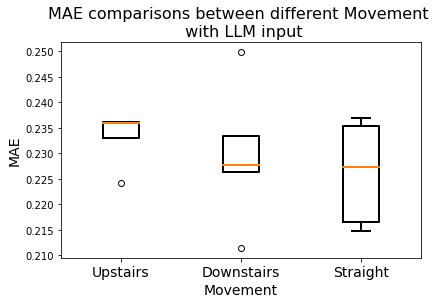

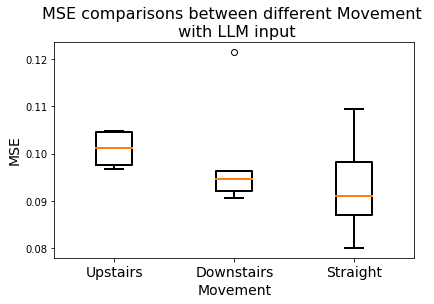

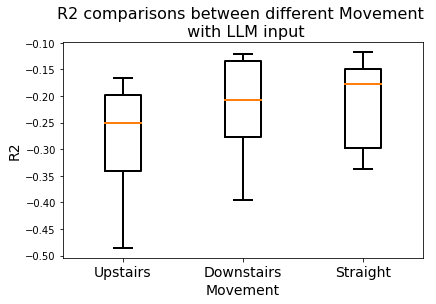

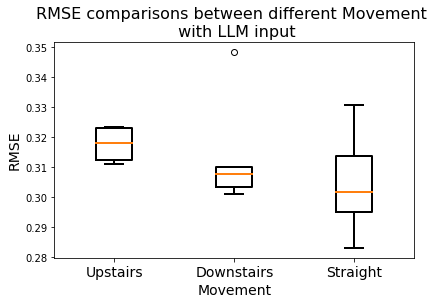

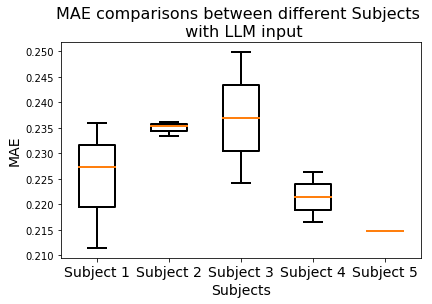

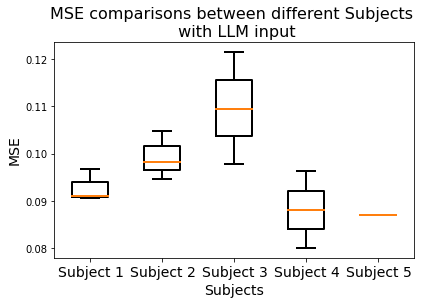

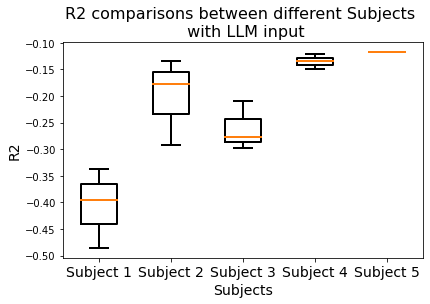

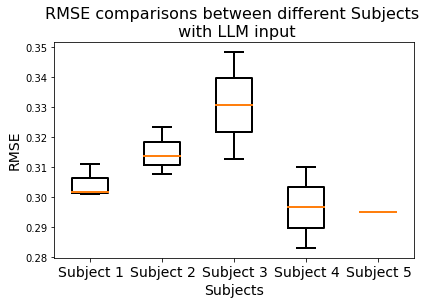

In [13]:

def sortData(dataList):
    MAE, MSE, R2, MAPE = [], [], [], []
    for i in dataList:
        tmpMAE, tmpMSE, tmpR2, tmpMAPE = [], [], [], []
        for j in i:
            tmpMAE.append(j[0])
            tmpMSE.append(j[1])
            tmpR2.append(j[2])
            tmpMAPE.append(j[3])
        MAE.append(tmpMAE)
        MSE.append(tmpMSE)
        R2.append(tmpR2)
        MAPE.append(tmpMAPE)
    return MAE, MSE, R2, MAPE

SortedMovementResults = sortData(movementResults)
SortedPeopleResults = sortData(peopleResults)
labels = ["MAE","MSE","R2","RMSE"]
movementNames = ["Upstairs", "Downstairs", "Straight"]
peopleNames = ["Subject 1", "Subject 2", "Subject 3", "Subject 4", "Subject 5"]
def makeBoxplots(data, names,labels, label):

    for i in range(len(data)):
        fig = plt.figure(figsize =(5, 3))
        ax = fig.add_axes([0, 0, 1, 1])
        bp = ax.boxplot(data[i],boxprops=dict(linewidth=2),whiskerprops=dict(linewidth=2),capprops=dict(linewidth=2),medianprops=dict(linewidth=2))
        ax.set_title(f"{labels[i]} comparisons between different {label} \n with LLM input",fontsize=16)
        ax.set_ylabel(labels[i],fontsize=14)
        ax.set_xlabel(label,fontsize=14)
        #ax.set_ylim(0.28,0.37)
        ax.set_xticklabels(names,fontsize=14)
    return fig

makeBoxplots(SortedMovementResults,movementNames,labels,"Movement")
makeBoxplots(SortedPeopleResults,peopleNames,labels,"Subjects")



plt.show()

In [14]:
def autoregressive_predict_with_errors(model, data_dict,start,stepLength,predSteps, seq_length):
    model.eval()

    feature_keys = list(data_dict.keys())
    #seq_length = len(data_dict[feature_keys[0]])
    #seq_length = seq_length*stepLength

    ground_truth = np.array([[data_dict[k][start+i*stepLength] for k in feature_keys] for i in range(seq_length)])

    current_input = torch.tensor(ground_truth[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,num_features)
    truth = []
    predictions = []
    errors = []
    tmpCount = 0
    check = True
    checkCount = 0
    scalingFactor = 1

    with torch.no_grad():
        for t in range(1, seq_length):
            pred = model(current_input)  # (1,1,num_features)
            pred_step = pred.squeeze(0).squeeze(0).cpu().numpy()
            
            if checkCount == 0 and check:
                scalingFactor = ground_truth[t]/pred_step
                check = False

            pred_step = pred_step*scalingFactor

            predictions.append(pred_step)
            # Calculate step MSE
            step_error = np.mean(np.abs(pred_step - ground_truth[t]))
            truth.append(ground_truth[t])
            errors.append(step_error)
            checkCount = checkCount + 1
            if tmpCount != predSteps:
                current_input = pred.unsqueeze(0)  # feed predicted step as input
                tmpCount = tmpCount + 1
            else:
                tmpCount = 0
                current_input = torch.tensor(ground_truth[t], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    truth = np.array(truth)
    predictions = np.array(predictions)  # shape (seq_length-1, num_features)

    return predictions, truth, errors


dfWalk1 = grabDataThigh(upstairsFilename1)
dataWalk1 = fixTimeData(dfWalk1)
dataWalk1.pop('type')
dataWalk1["Class"] = list(1 for i in range(len(dataWalk1["time"])))
data = checkDictForStr(dataWalk1)
data = fixData(data,normalize,Time,True, Grav,Gyro,Quat,LiAcc,Classification)
data = processFSR(data, FSR, FSRsum, FSRavg)

dfWalk2 = grabDataThigh(upstairsFilename2,0)
#dataWalk2 = fixTimeData(dfWalk2)
dataWalk2 = dfWalk2.to_dict("list")
dataWalk2.pop('type')
dataWalk2["Class"] = list(1 for i in range(len(dataWalk2["time"])))
data2 = checkDictForStr(dataWalk2)
data2 = fixData(data2,normalize,Time,True, Grav,Gyro,Quat,LiAcc,Classification)
data2 = processFSR(data2, FSR, FSRsum, FSRavg)

dfWalk3 = grabDataThigh(upstairsFilename3,0)
#dataWalk3 = fixTimeData(dfWalk3)
dataWalk3 = dfWalk3.to_dict("list")
dataWalk3.pop('type')
dataWalk3["Class"] = list(1 for i in range(len(dataWalk3["time"])))
data3 = checkDictForStr(dataWalk3)
data3 = fixData(data3,normalize,Time,True, Grav,Gyro,Quat,LiAcc,Classification)
data3 = processFSR(data3, FSR, FSRsum, FSRavg)

dfWalk4 = grabDataThigh(upstairsFilename4)
dataWalk4 = fixTimeData(dfWalk4)
dataWalk4.pop('type')
dataWalk4["Class"] = list(1 for i in range(len(dataWalk4["time"])))
data4 = checkDictForStr(dataWalk4)
data4 = fixData(data4,normalize,Time,True, Grav,Gyro,Quat,LiAcc,Classification)
data4 = processFSR(data4, FSR, FSRsum, FSRavg)

'''
dfWalk5 = grabDataThigh(upstairsFilename5)
dataWalk5 = fixTimeData(dfWalk5)
dataWalk5.pop('type')
dataWalk5["Class"] = list(0 for i in range(len(dataWalk5["time"])))
data5 = checkDictForStr(dataWalk5)
data5 = fixData(data5,normalize,Time,True, Grav,Gyro,Quat,LiAcc,Classification)
data5 = processFSR(data5, FSR, FSRsum, FSRavg)
'''
dataDicts = [data,data2,data3,data4]#,data5]
sequenceLength = 150
start = 350
truths = []
preds = []
all_errors = []

for i, d in enumerate(dataDicts):
    predictions, groundTruth, errors = autoregressive_predict_with_errors(model, d,start, timeStep, 0, sequenceLength)
    preds.append(predictions)
    truths.append(groundTruth)
    all_errors.append(errors)
'''
plt.figure(figsize=(10,6))

for i, errors in enumerate(all_errors):
    plt.plot(errors, label=f'Subject {i+1}')
'''
def sortTruthPred(predictions,groundTruth):
    sortedPredictions = [[],[],[],[],[],[],[],[]]
    sortedTruths = [[],[],[],[],[],[],[],[]] 
    for j in range(len(predictions)):
        for i in range(8):
            sortedPredictions[i].append(predictions[j][i])
            sortedTruths[i].append(groundTruth[j][i])
    return sortedPredictions, sortedTruths

truthsSorted = []
predsSorted = []
scalingFactor = []
check = -50
for i in range(len(preds)):
    count = 0
    tmpFactor = 0
    for j in range(len(truths[i][0])):
        tmpCalc = truths[i][0][j]/preds[i][0][j]
        if check < tmpCalc < abs(check):
            count = count + 1
            tmpFactor = tmpFactor + abs(tmpCalc)
    scalingFactor.append(tmpFactor/count)

print(scalingFactor)

for i in range(len(scalingFactor)):
    scalingFactor[i] = 1

print(scalingFactor)

for i in range(len(preds)):
    sortedPredictions, sortedTruths = sortTruthPred(preds[i],truths[i])
    #sortedPredictions = (np.array(sortedPredictions)*scalingFactor[i]).tolist()
    truthsSorted.append(sortedTruths)
    predsSorted.append(sortedPredictions)




C:\Users\jonas\AppData\Local\Temp\ipykernel_19812\2906205059.py:57: RuntimeWarning: invalid value encountered in true_divide
  column = list((data - min(data)) / (max(data) - min(data)))
C:\Users\jonas\AppData\Local\Temp\ipykernel_19812\2906205059.py:57: RuntimeWarning: invalid value encountered in true_divide
  column = list((data - min(data)) / (max(data) - min(data)))
C:\Users\jonas\AppData\Local\Temp\ipykernel_19812\2906205059.py:57: RuntimeWarning: invalid value encountered in true_divide
  column = list((data - min(data)) / (max(data) - min(data)))
C:\Users\jonas\AppData\Local\Temp\ipykernel_19812\2906205059.py:57: RuntimeWarning: invalid value encountered in true_divide
  column = list((data - min(data)) / (max(data) - min(data)))


ZeroDivisionError: division by zero

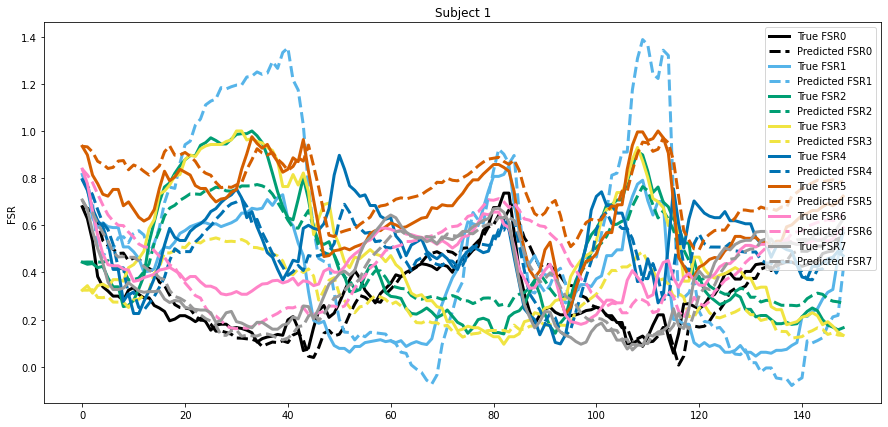

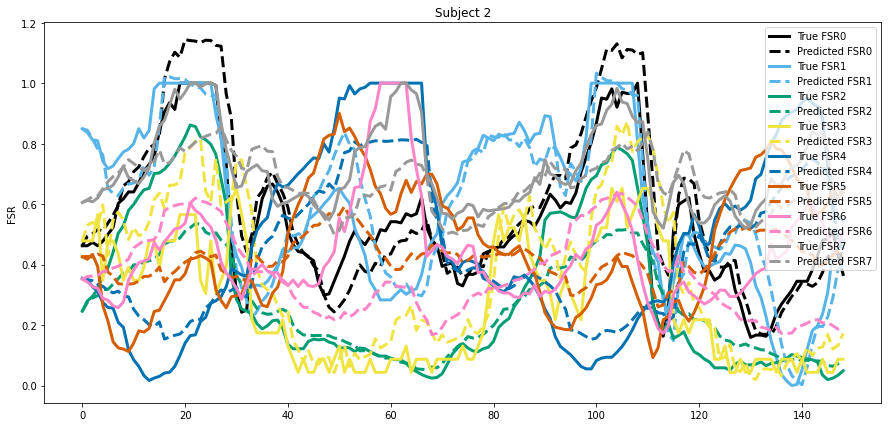

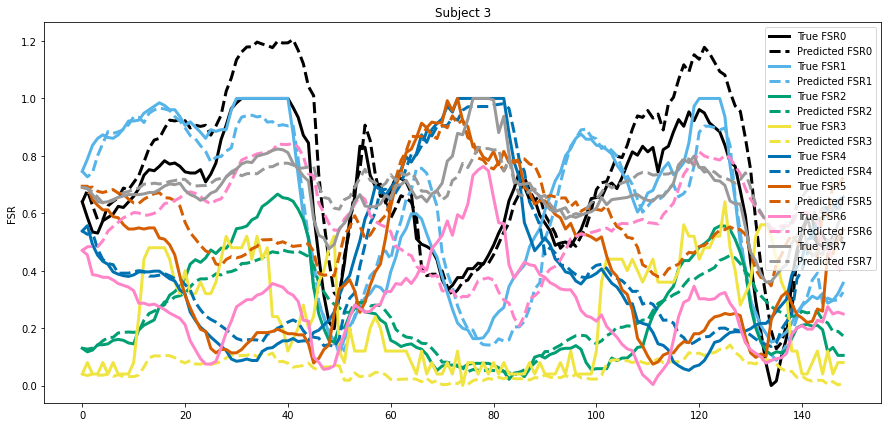

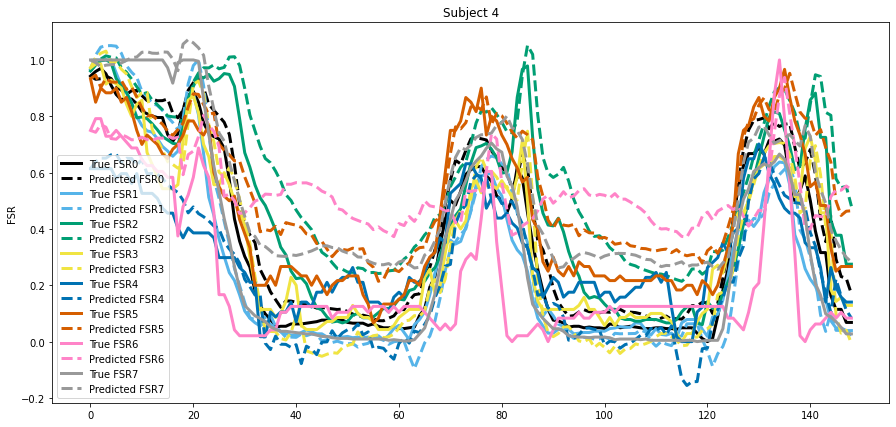

In [ ]:
k = 1
color_list = [
    "#000000",  # Orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Bluish Green
    "#F0E442",  # Yellow
    "#0072B2",  # Blue
    "#D55E00",  # Vermillion (not pure red)
    "#FF84C8",  # Reddish Purple
    "#999999",  # Grey
]


x = [i for i in range(sequenceLength-1)]
for j in range(len(truthsSorted)):
    fig, ax = plt.subplots(1,1,sharey=True,figsize=(15,7))
    for i in range(8):
        ax.plot(x,truthsSorted[j][i],label=f"True FSR{i}",color=color_list[i],linewidth=3)
        ax.plot(x,predsSorted[j][i],label=f"Predicted FSR{i}",linewidth=3,color=color_list[i], linestyle='dashed')
        ax.set_ylabel('FSR')
        ax.set_title(f'Subject {j+1}')
        ax.legend()
        
    #ax[0].set_xlabel('Prediction Step')
    #ax[1].set_xlabel('Prediction Step')
    
    #fig.set_title('Prediction MAE per Step for Multiple Sequences')
    #ax[0].set_title("Truth")
    #ax[1].set_title("Predicted and scaled")
    plt.show()

Accuracy: 0.7031
Accuracy: 0.6562


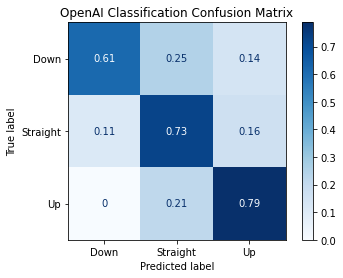

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

filename1 = r'C:\Users\jonas\Documents\GitHub\P8\Code\Data\Confusion Matrix\frame_intent_classification_blind_Jonas_Walking_Sequence.csv'
filename2 = r'C:\Users\jonas\Documents\GitHub\P8\Code\Data\Confusion Matrix\frame_intent_classification_blind_Walk_Svend.csv'
filename3 = r'C:\Users\jonas\Documents\GitHub\P8\Code\Data\Confusion Matrix\frame_intent_classification_Svend_upstairs_downstairs.csv'
filename4 = r'C:\Users\jonas\Documents\GitHub\P8\Code\Data\Confusion Matrix\video_step_classification_Asbjørn.csv'


# List your CSV file names here
file_list = [filename2, filename3, filename4]

# Read and concatenate all files
df_list = [pd.read_csv(file) for file in file_list]
df = pd.concat(df_list, ignore_index=True)

import numpy as np
from scipy.signal import medfilt

# Suppose your column is 'classification'
# Choose an odd window size, e.g., 3, 5, 7, etc.
window_size = 5  # Change this to increase window size

# Apply median filter
df['classification_denoised'] = medfilt(df['classification'], kernel_size=window_size)

# Make sure the columns are named 'classification' and 'truth'
# Compute the confusion matrix
labels = [-1, 0, 1]  # -1: Down stairs, 0: Straight, 1: Up stairs
cm = confusion_matrix(df['truth'], df['classification_denoised'], labels=labels,normalize="true")
# Calculate accuracy
correct = (df['classification_denoised'] == df['truth']).sum()
total = len(df)
accuracy = correct / total

print(f"Accuracy: {accuracy:.4f}")
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df['truth'], df['classification'])
print(f"Accuracy: {accuracy:.4f}")

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Straight', 'Up'])
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("OpenAI Classification Confusion Matrix")
plt.show()